# Around Black-Scholes and Local Volatility

We offer you the following practical task on Black-Scholes and local volatility models.

Total score is **100**, which will be converted to $15\%$ of the course grade. You have 2 weeks and a half for this work. **Soft deadline is the 28th of October, 23:59 MSK**. Hard deadline is the 1st of November, 23:59 MSK.

Please rename your file as **"SurnameName_Lab1.ipynb"** before attaching as a solution in the LMS.

If you have any questions feel free to ask in the **group chat**.

**Full name:** Петрова Елизавета Андреевна

**Faculty:** Прикладной анализ данных и искусственный интеллект, ВШЭ

In [1]:
### YOUR IMPORTS HERE

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats as st
from collections.abc import Callable
from tqdm.auto import trange

## Episode 1: Around Black-Scholes model (50 points)

**1**. <span style="color:blue">(10 points)</span>

A call spread is an option strategy in which a call option is bought, and another less expensive call option is sold. That is, the payoff of the call spread at expiration $T$ can be given as

$$\text{Call-spread}(K_1, K_2) = (S_T - K_1)_{+} - (S_T - K_2)_{+}, \qquad K_1 < K_2.$$

Plot **call-spread** option prices as functions of the underlying asset price for different **exercise times** and different **volatilities**. Use parameters

$$K_1 = 1, \quad K_2 = 1.2, \quad r = 0, \quad S \in [0.5, 1.5],$$

and $T \in \{0,\ \frac{1}{4},\ \frac{1}{2},\ \frac{3}{4},\ 1\}$ (time is measured in years) and $\sigma \in \{0.1, \ 0.2, \ 0.3\}$.

*Note: the answer should contain three plots (for each volatility $\sigma$), each of which shows option prices for different excercise times $T$.*

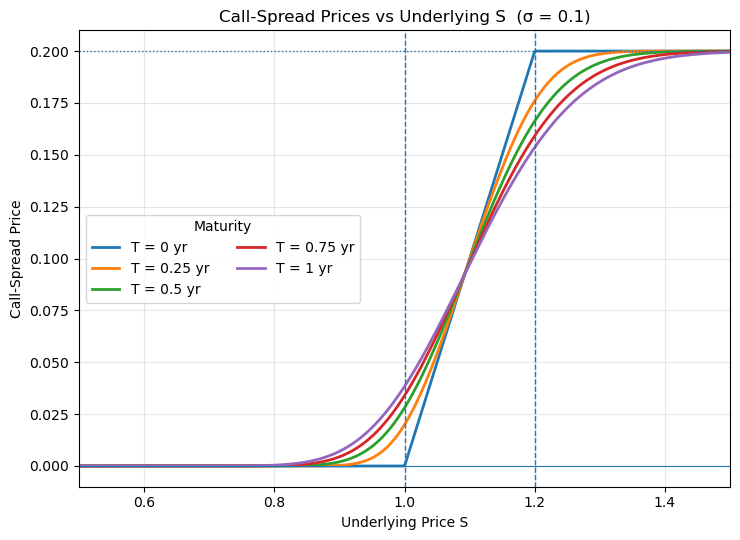

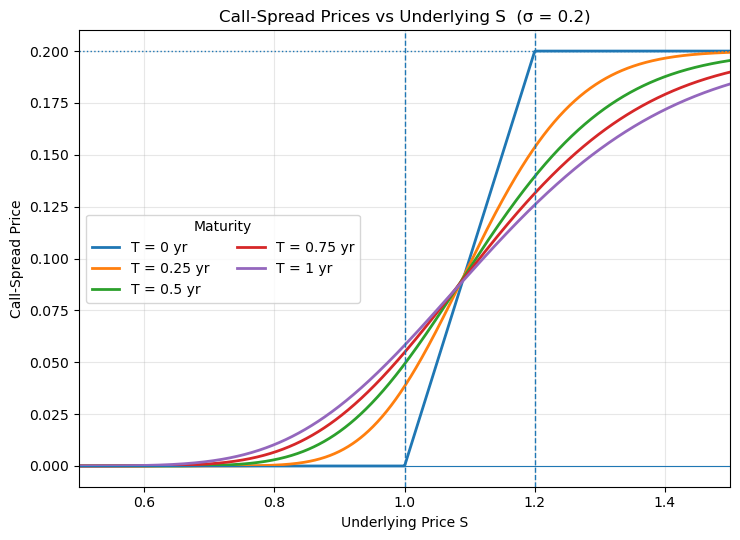

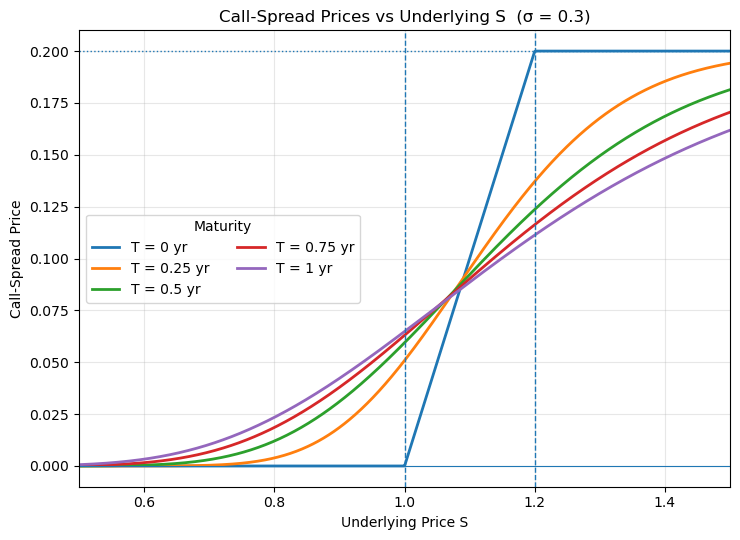

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

K1 = 1.0
K2 = 1.2
r = 0.0
S_min, S_max = 0.5, 1.5
S = np.linspace(S_min, S_max, 1000)

T_list = [0.0, 0.25, 0.5, 0.75, 1.0]
sigmas = [0.1, 0.2, 0.3]


def bs_call_price(S, K, T, sigma, r=0.0):
    """
    Black–Scholes price of a European call.
    Handles T = 0 by returning the intrinsic value.
    Vectorized in S.
    """
    S = np.asarray(S, dtype=float)
    if T == 0.0:
        return np.maximum(S - K, 0.0)

    # Avoid numerical issues if sigma=0 or extremely small T
    sqrtT = np.sqrt(T)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT

    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


def call_spread_price(S, K1, K2, T, sigma, r=0.0):
    """Long call at K1, short call at K2 (K1 < K2)."""
    return bs_call_price(S, K1, T, sigma, r) - bs_call_price(S, K2, T, sigma, r)


# Plot: one figure per volatility, multiple curves for different maturities
for sigma in sigmas:
    plt.figure(figsize=(7.5, 5.5))
    for T in T_list:
        price = call_spread_price(S, K1, K2, T, sigma, r)
        lbl = f"T = {T:g} yr"
        plt.plot(S, price, label=lbl, linewidth=2)

    # Visual aids: strikes and max payoff
    # Max payoff of a call spread is (K2 - K1)
    max_payoff = (K2 - K1)
    plt.axvline(K1, linestyle="--", linewidth=1)
    plt.axvline(K2, linestyle="--", linewidth=1)
    plt.axhline(0.0, linestyle="-", linewidth=0.8)
    plt.axhline(max_payoff, linestyle=":", linewidth=1)

    plt.title(f"Call-Spread Prices vs Underlying S  (σ = {sigma})")
    plt.xlabel("Underlying Price S")
    plt.ylabel("Call-Spread Price")
    plt.xlim(S_min, S_max)
    plt.legend(title="Maturity", ncol=2, frameon=True)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

plt.show()

**2**. <span style="color:blue">(10 points)</span>  What kind of dependence on the parameters of call-spread option price do you observe? How does the price of it depend on the spot price $S$, volatility $\sigma$ and time to expiration $T$? Why? Provide the intuition.

# Dependence on the spot (S)

* Monotone increasing, but capped. The price is non-decreasing in (S) and is bounded:
  $$
  0 \leq \text{CS}(S) \leq K_2-K_1.
  $$
  As $T\to0$, the price approaches the intrinsic, a piecewise-linear “ramp” that rises from 0 near $S\approx K_1$ and flattens at $K_2-K_1$ above $K_2$.

* Slope (delta) profile—hump shaped.
  Delta is near 0 when $S\ll K_1$ (both calls far OTM), rises toward ~1 between the strikes (the long $K_1$ is ITM while the short $K_2$ is still OTM), and then falls back toward 0 for $S\gg K_2$ (both calls ITM with similar deltas that cancel). So the spread is most sensitive to S when S lies between $K_1$ and $K_2$.

* Curvature (gamma) shifts sign across the strikes.
  Net gamma is positive around $K_1$ (long call dominates) and negative around $K_2$ (short call dominates), producing an S-shaped price curve that increases and then flattens.

**Intuition:** The payoff is $\min\big((S_T-K_1)_+,K_2-K_1\big)$. Raising today’s S lifts the whole distribution of $S_T$, increasing the chance the spread lands in its paying region $[K_1,K_2]$, but once the top leg engages (above $K_2$) the payoff is capped, so further increases in S add little value.

# Dependence on volatility $\sigma$

* Mostly positive between the strikes; small or even negative near/above $K_2$.
  Vega of a single call is largest when it’s near-the-money. In the spread:

  * For S between $K_1$ and $K_2$, the long $K_1$ is near-/slightly-ITM (high vega) while the short $K_2$ is OTM (lower vega) ⇒ net vega > 0. More volatility helps because it raises the probability of finishing in the profitable band $[K_1,K_2]$ before the cap bites.
  * For $S \ll K_1$, both legs are OTM, vegas are small; the effect is positive but weak (volatility gives a chance to enter the band).
  * For $S \approx K_2$ or $S \gg K_2$, the short leg’s vega can dominate or both vegas shrink. Extra volatility increases the chance of ending above $K_2$ where the payoff is already capped, so additional dispersion doesn’t help (and near $K_2$ can hurt) ⇒ net vega ≈ 0 to negative.

**Intuition:** Volatility widens the distribution of $S_T$. The spread only benefits from outcomes that move into the window $[K_1,K_2]$; once above $K_2$, you’re short the extra upside. Hence, volatility is beneficial mainly when today’s S is below/inside the window and harmful/neutral near and above the upper strike.

# Dependence on time to expiration (T)

* Sign depends on moneyness; non-monotone across S.

  * Deep OTM ($S\ll K_1$): More time increases the chance to reach the paying region ⇒ price increases with T (positive time value).
  * Between $K_1$ and $K_2$: Similar to volatility—more time generally helps because it increases the chance to remain in or migrate within $[K_1,K_2]$ without breaching the cap ⇒ usually increases with T.
  * Near/above $K_2$: The spread is near its cap. Extra time introduces downside risk (you could fall back below $K_2$) but gives no further upside beyond the cap ⇒ price can decrease with T (negative theta region).
* As $T \downarrow 0$, the price converges to the intrinsic “capped ramp”; as T grows, the curve becomes smoother and bows away from the intrinsic according to the signs above.

**Intuition:** Time is valuable when it offers profitable paths that aren’t capped (reaching $[K_1,K_2]$ from below). When you’re already at the cap, extra time only adds risk of losing value, not gaining more, so time can be detrimental there.

**3**. <span style="color:blue">(10 points)</span> Replicate considered call-spread option using the portfolio rebalanced $n$ times (i.e. every $dt = T/n$ units of time). Using simulations, estimate the distribution of the replication error.


    1) Generate m random trajectories of price process trajectories on the segment [0,t] with a step dt = T/n.

    2) For each trajectory at each moment of time, find a replicating portfolio. Assume that the initial value of the portfolio is equal to the option price.

    3) For each trajectory, calculate the difference between the value of the replicating portfolio at time T and the payout to be made on the option.

    4) Display the distribution of the obtained differences in the form of a histogram.

*Note: use, for instance, $m = 2^{10} - 1$ and $n$ = 123*.

*Note: Remember that you are replicating your call-spread in Black-Scholes model. So, you may use any formulas available in this model (Black-Scholes option's price formula, greeks, etc.) .*

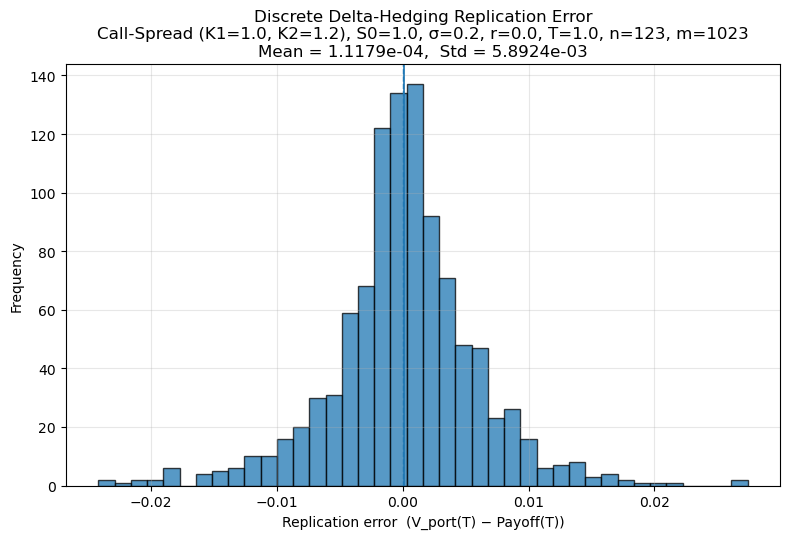

Option price at t=0: 0.058183
Empirical mean error: 1.117942e-04
Empirical std  error: 5.892446e-03


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

S0 = 1.0
K1 = 1.0
K2 = 1.2
r = 0.0
sigma = 0.2
T = 1.0

m = 2 ** 10 - 1  # number of simulated paths: 1023
n = 123  # number of re-hedges (time steps)
dt = T / n

rng = np.random.default_rng(42)  # for reproducibility


# Black–Scholes helpers
def bs_call_price(S, K, tau, sigma, r=0.0):
    """Black–Scholes European call price. Handles tau=0 by intrinsic value."""
    S = np.asarray(S, dtype=float)
    if tau <= 0.0:
        return np.maximum(S - K, 0.0)
    sqrt_tau = np.sqrt(tau)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * sqrt_tau)
    d2 = d1 - sigma * sqrt_tau
    return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)


def bs_call_delta(S, K, tau, sigma, r=0.0):
    """Black–Scholes delta of a European call. For tau=0, use 1_{S>K}."""
    S = np.asarray(S, dtype=float)
    if tau <= 0.0:
        # At expiry the (right-continuous) delta is 1 if S>K, else 0 (ties have measure zero)
        return (S > K).astype(float)
    sqrt_tau = np.sqrt(tau)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * sqrt_tau)
    return norm.cdf(d1)


def call_spread_price(S, K1, K2, tau, sigma, r=0.0):
    return bs_call_price(S, K1, tau, sigma, r) - bs_call_price(S, K2, tau, sigma, r)


def call_spread_delta(S, K1, K2, tau, sigma, r=0.0):
    return bs_call_delta(S, K1, tau, sigma, r) - bs_call_delta(S, K2, tau, sigma, r)


# Simulate price paths
# S_{t+dt} = S_t * exp((r - 0.5*sigma^2)dt + sigma*sqrt(dt)*Z)
Z = rng.standard_normal(size=(n, m))
drift = (r - 0.5 * sigma ** 2) * dt
diffu = sigma * np.sqrt(dt)

S_paths = np.empty((n + 1, m))
S_paths[0, :] = S0
for i in range(n):
    S_paths[i + 1, :] = S_paths[i, :] * np.exp(drift + diffu * Z[i, :])

# Build replicating portfolio
# Initial option price and delta (same sigma used for pricing and hedging)
V0 = call_spread_price(S0, K1, K2, T, sigma, r)
delta0 = call_spread_delta(S0, K1, K2, T, sigma, r)

# We create one self-financing hedging portfolio per path
# Positions at t=0:
shares = np.full(m, delta0)  # Δ_0 shares held
cash = np.full(m, V0 - delta0 * S0)  # cash account so that shares + cash = option value

# Rebalance at each grid time t_i -> t_{i+1}:
for i in range(n):
    t_i = i * dt
    t_ip1 = (i + 1) * dt
    tau_ip1 = T - t_ip1  # time-to-maturity at t_{i+1}
    S_ip1 = S_paths[i + 1, :]  # trade at the re-hedge time t_{i+1}

    # Cash accrues interest over [t_i, t_{i+1}]
    if r != 0.0:
        cash *= np.exp(r * dt)

    # Compute new delta at t_{i+1} and rebalance at price S_{i+1}
    new_delta = call_spread_delta(S_ip1, K1, K2, tau_ip1, sigma, r)

    dDelta = new_delta - shares
    cash -= dDelta * S_ip1  # buy/sell dDelta shares
    shares = new_delta  # update share holdings

S_T = S_paths[-1, :]
if r != 0.0:
    # Cash has already been grown to t_{i+1} each step; at T we are done
    pass

V_port_T = shares * S_T + cash
payoff_T = np.maximum(S_T - K1, 0.0) - np.maximum(S_T - K2, 0.0)
replication_error = V_port_T - payoff_T  # positive = over-hedged; negative = under-hedged

mean_err = np.mean(replication_error)
std_err = np.std(replication_error, ddof=1)

plt.figure(figsize=(8, 5.5))
plt.hist(replication_error, bins=40, edgecolor='k', alpha=0.75)
plt.axvline(0.0, linestyle='--', linewidth=1)
plt.axvline(mean_err, linestyle='-', linewidth=1.2)
plt.title(
    "Discrete Delta-Hedging Replication Error\n"
    f"Call-Spread (K1={K1}, K2={K2}), S0={S0}, σ={sigma}, r={r}, T={T}, n={n}, m={m}\n"
    f"Mean = {mean_err:.4e},  Std = {std_err:.4e}"
)
plt.xlabel("Replication error  (V_port(T) − Payoff(T))")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Option price at t=0: {V0:.6f}")
print(f"Empirical mean error: {mean_err:.6e}")
print(f"Empirical std  error: {std_err:.6e}")

**4**. <span style="color:blue">(20 points)</span> Let $C_{call} (S_t, r, \sigma, t) := C(t, S_t)$ be a call option price where $C(t, S)$ satisfies BS equation. Suppose that we sell a call option at $t=0$ at implied volatility $\hat \sigma$, i.e. we get the premium $C_{call}(S_0, r, \hat \sigma, 0)$. Hence the hedging strategy is such that the number of the risky asset held at time $t$ is $$H_t = \dfrac{\partial C}{\partial S}.$$ Moreover, suppose that the true dynamics of asset price is **not** geometric Brownian motion $dS_t = r S_t dt + \sigma S_t dW_t$, but is given by more general Ito process

$$dS_t = \alpha_t S_t dt + \beta_t S_t dW_t. $$

4.1 <span style="color:blue">(2 points out of 20)</span> Using strategy $H_t$, write SDE for the value $X_t$ of hedging portfolio, assuming that we hold $\dfrac{\partial C}{\partial S}$ units of risky asset and $X_t - \dfrac{\partial C}{\partial S} S_t$ money in riskless one.

Here’s the self-financing SDE for the hedging portfolio when you hold
$$H_t=\frac{\partial C}{\partial S}(t,S_t)$$
shares of the risky asset and keep the rest in the money market at rate r.

* **Portfolio value**
  $$
  X_t = H_t S_t + \bigl(X_t - H_t S_t\bigr).
  $$

* **Self-financing dynamics**
  $$
  dX_t = H_t dS_t + r\bigl(X_t - H_t S_t\bigr)dt.
  $$

* **Plug in $H_t=\frac{\partial C}{\partial S}(t,S_t)$ and the true Itô dynamics**
  $$
  dS_t = \alpha_t S_tdt + \beta_t S_t dW_t,
  $$
  to get
  $$
  dX_t = \frac{\partial C}{\partial S}(t,S_t)(\alpha_t S_t,dt+\beta_t S_tdW_t)
  + r\Bigl(X_t-\frac{\partial C}{\partial S}(t,S_t)S_t\Bigr)dt.
  $$

* **Collected terms**
  $$
  dX_t = r X_tdt
  + \frac{\partial C}{\partial S}(t,S_t)S_t(\alpha_t - r)dt
  + \frac{\partial C}{\partial S}(t,S_t)\beta_t S_t dW_t.
  $$

* **Initial condition (we sold at implied volatility $\hat\sigma$)**
  $$
  X_0 = C_{\text{call}}(S_0,r,\hat\sigma,0).
  $$

This SDE is exactly the self-financing delta-hedging portfolio driven by the true drift/volatility $(\alpha_t,\beta_t)$, while deltas are computed from C(t,S) (the Black–Scholes price surface you hedge with).


4.2 <span style="color:blue">(2 points out of 20)</span> Assume that $Y_t = C(t, S_t)$. Applying Ito formula to $Y_t$, write SDE for $Y_t$.

Here Y_t = $C(t,S_t)$ with $C\in C^{1,2}$ and the true Itô dynamics
$$
dS_t = \alpha_t S_tdt + \beta_t S_tdW_t .
$$

By Itô’s formula,
$$
dY_t = \frac{\partial C}{\partial t}(t,S_t)dt
+ \frac{\partial C}{\partial S}(t,S_t)dS_t
+ \tfrac12\frac{\partial^2 C}{\partial S^2}(t,S_t)(dS_t)^2 .
$$

Substitute $dS_t$ and use $(dW_t)^2=dt$:
$$
dY_t = \Big[
C_t(t,S_t) + \alpha_t S_t C_S(t,S_t) + \tfrac12\beta_t^2 S_t^2 C_{SS}(t,S_t)
\Big] dt
+ \beta_t S_t C_S(t,S_t) dW_t .
$$

Here $C_t=\partial C/\partial t$, $C_S=\partial C/\partial S$, $C_{SS}=\partial^2 C/\partial S^2$.


4.3 <span style="color:blue">(6 points out of 20)</span> Using answers from 5.1 and 5.2 (4.1 and 4.2, i fixed the numeration in my notebook) and BS equation, show that hedging error $Z_t = X_t - Y_t$ satisfies

$$\dfrac{d}{dt} Z_t = r Z_t + \dfrac{1}{2} S_t^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta^2_t \right).$$

* Hedging portfolio (from 4.1):
  $$
  dX_t = r X_tdt + C_S(t,S_t)S_t(\alpha_t - r)dt + C_S(t,S_t)\beta_t S_t dW_t.
  $$

* Option value (from 4.2):
  $$
  dY_t = \Big[ C_t(t,S_t) + \alpha_t S_t C_S(t,S_t) + \tfrac12 \beta_t^2 S_t^2 C_{SS}(t,S_t) \Big] dt + \beta_t S_t C_S(t,S_t) dW_t.
  $$

* Define the hedging error $Z_t := X_t - Y_t$ and subtract:
  $$
  dZ_t
  = dX_t - dY_t = \Big[ r X_t + C_S S_t(\alpha_t - r) - C_t - \alpha_t S_t C_S - \tfrac12 \beta_t^2 S_t^2 C_{SS} \Big] dt
  + \big[ C_S \beta_t S_t - \beta_t S_t C_S \big] dW_t
  = \Big[ r X_t - r S_t C_S - C_t - \tfrac12 \beta_t^2 S_t^2 C_{SS} \Big] dt,
  $$
  since the $dW_t$ terms cancel.

* Use the Black–Scholes PDE at implied volatility $\hat\sigma$:
  $$
  C_t + r S_t C_S + \tfrac12 \hat\sigma^2 S_t^2 C_{SS} - r C = 0
  \Rightarrow -C_t = - r S_t C_S - \tfrac12 \hat\sigma^2 S_t^2 C_{SS} + r C
  $$

* Substitute into $dZ_t$:
  $$
  dZ_t = \Big[ r X_t - r S_t C_S + \big(- C_t\big) - \tfrac12 \beta_t^2 S_t^2 C_{SS} \Big] dt = \Big[ r X_t - r S_t C_S + \big(- r S_t C_S - \tfrac12 \hat\sigma^2 S_t^2 C_{SS} + r C\big) - \tfrac12 \beta_t^2 S_t^2 C_{SS} \Big] dt = \Big[ r(X_t - C) + \tfrac12 S_t^2 C_{SS}(\hat\sigma^2 - \beta_t^2) \Big] dt
  $$

Since $Z_t = X_t - Y_t = X_t - C(t,S_t)$, we obtain
$$
\boxed{\dfrac{d}{dt} Z_t = r Z_t + \dfrac{1}{2} S_t^2 C_{SS}(t,S_t) \big(\hat \sigma^2 - \beta_t^2\big) }
$$


4.4 <span style="color:blue">(6 points out of 20)</span> Solve the equation for $Z_t$ above and show that

$$Z_T = \int_{0}^{T} e^{r(T-s)} \dfrac{1}{2} S_t^2 \dfrac{\partial^2 C}{\partial S^2} \left( \hat \sigma^2 - \beta_t^2 \right) dt $$

Start from the linear ODE (pathwise, no $dW$ term)
$$
\frac{d}{dt}Z_t = rZ_t + \frac{1}{2}S_t^2C_{SS}(t,S_t)(\hat\sigma^2-\beta_t^2)
$$

Use the integrating factor $e^{-rt}$:
$$
\frac{d}{dt}\bigl(e^{-rt}Z_t\bigr)
= e^{-rt}\Bigl[\frac{d}{dt}Z_t - r Z_t\Bigr]
= e^{-rt}\cdot \frac{1}{2}S_t^2C_{SS}(t,S_t)(\hat\sigma^2-\beta_t^2)
$$

Integrate from 0 to T:
$$
e^{-rT}Z_T - Z_0
= \int_0^T e^{-rs}\frac{1}{2}S_s^2C_{SS}(s,S_s)(\hat\sigma^2-\beta_s^2)ds.
$$

Because we sold the option at t=0 and set the hedge so that $X_0=Y_0=C_{\text{call}}(S_0,r,\hat\sigma,0)$, we have $Z_0=X_0-Y_0=0$. Hence
$$
Z_T
= e^{rT}\int_0^T e^{-rs}\frac{1}{2}S_s^2C_{SS}(s,S_s)(\hat\sigma^2-\beta_s^2)ds
= \int_0^T e^{r(T-s)}\frac{1}{2}S_s^2C_{SS}(s,S_s)(\hat\sigma^2-\beta_s^2)ds
$$

Renaming the dummy variable back to t if desired gives
$$
Z_T = \int_{0}^{T} e^{r(T-t)} \frac{1}{2} S_t^2  C_{SS}(t,S_t)  \bigl( \hat \sigma^2 - \beta_t^2 \bigr) dt.
$$


4.5 <span style="color:blue">(4 points out of 20)</span> Looking at the results above, is it possible to make a **profit with probability one** even though the true price model is substantially different from the assumed model (GBM)? What condition is sufficient for getting this profit?

Yes—for a vanilla call (convex payoff) you can lock in a sure profit (super-hedge) despite model misspecification.

From the tracking-error identity you derived,
$$
Z_T = \int_0^T e^{r(T-t)}\frac{1}{2}S_t^2C_{SS}(t,S_t)\bigl(\hat\sigma^2-\beta_t^2\bigr)dt,
$$
note that for a call option
$$
C_{SS}(t,S_t)>0\quad\text{for }t<T,
$$
and obviously $e^{r(T-t)}>0$ and $S_t^2\ge0$. Hence the sign of $Z_T$ is entirely controlled by $\hat\sigma^2-\beta_t^2$.

* Sufficient condition for profit with probability one (super-replication):
  $$
  \hat\sigma^2 \ge \beta_t^2 \quad \text{for all } t\in[0,T]\ \text{a.s.}
  $$
  Then the integrand is nonnegative for all t, so
  $$
  Z_T \ge 0 \quad \text{a.s.}
  $$
  If the inequality is strict on a set of times of positive Lebesgue measure (a.s.), then
  $$
  Z_T > 0 \quad \text{a.s.,}
  $$
  i.e., profit with probability one.

* Interpretation. Using a hedging volatility $\hat\sigma$ that upper-bounds the true instantaneous volatility $\beta_t$ produces a model-independent super-hedge for any convex payoff: you sell the option at the higher price implied by $\hat\sigma$ and delta-hedge with that surface; the residual $Z_T$ is nonnegative pathwise. Conversely, if $\hat\sigma^2\le \beta_t^2$ a.s., you get a pathwise loss for convex payoffs.

So, a concise sufficient condition is:
$$
\boxed{\ \hat\sigma \ge esssup_{t\in[0,T]} \beta_t\ \ \text{(a.s.)}\ }
$$
(with strict > on a set of positive time length to ensure strictly positive profit a.s.).


## Episode 2: Local volatility from Monte Carlo perspective (50 points)

Here you need to implement the Monte-Carlo pricing in Local Volatility model. For that purpose, you can use the standrad *Euler* discretization scheme:

$$S_{t_{i + 1}} = S_{t_i} + \sigma_{Dup}(t_i, S_{t_i}) \Delta W_{t_i}.$$

However, direct usage of such scheme may lead to negative values of the prices $S_t$. For that reason, you may apply the Euler scheme to $\log(S_{t_i})$ and then finally put $S_{t_i} = e^{X_{t_i}}$. From Ito's formula,

$$X_{t_{i + 1}} = X_{t_i} - \frac{1}{2} \sigma^2_{Dup}(t_i, e^{X_{t_i}}) \Delta t_i+ \sigma_{Dup}(t_i, e^{X_{t_i}}) \Delta W_{t_i}.$$

Notice that for correct implementation, you need a full Dupire volatility surface function. For that reason, you should construct a properly inter-and-extrapolated function $(t, s) \to \sigma_{IV}(t, s)$, obtained from real-market data. Then you may use the well-known formula converting the observed implied volatilites $\sigma_{IV}(t, s)$ to Dupire local volatilies $\sigma_{Dup}(t, s)$:

$$ \sigma_{Dup}(T, K) = \sqrt{\dfrac{\frac{\partial w}{\partial T}}{1 - \frac{y}{w} \frac{\partial w}{\partial y} + \frac{1}{4} ( -\frac{1}{4} - \frac{1}{w} + \frac{y^2}{w^2}) (\frac{\partial w}{\partial y})^2 + \frac{1}{2} \frac{\partial^2 w}{\partial y^2}}},$$


where
$w(K, T) = \sigma^{2}_{IV}(K, T) \cdot T$ is implied variance and $y = \log(K / F_T)$ is forward log-moneyness.

Use, for instace, spline interpolation in $(w, y)$ coordinates. You may use alo flat extrapolation, i.e. for a pair of arguments $(t, K)$, firstly make the following tranformation

$$ t' = \begin{cases} t_{\min}, & t<t_{\min} \\
   t,        & t \in[t_{\min}, t_{\max}],\\
   t_{\max}, & t > t_{\max},
        \end{cases} \qquad
$$

$$
   s = \begin{cases} s_{\min}, & s<s_{\min}, \\
                     s, & s \in[s_{\min}, s_{\max}], \\
                     s_{\\max}, & s > s_{\max},
        \end{cases} \qquad
$$

where $t_{\min}, t_{\max}, s_{\min}, s_{\max}$ - minimum and maximum values of time to expiration and strikes variables from the market data and
$$\sigma^{new}_{Dup}(t,s) = \sigma_{Dup}(t', s').$$


In [4]:
s = 1.0  # spot price S_0
r = 0.0  # zero interest rate

**1**. <span style="color:blue">(10 points)</span>

Extract the data from `data.txt`: strikes, times to expiration and call option prices. Compute the corresponding implied volatilties $\sigma_{IV}(T_i, K_i)$, inter-and-extrapolate them to obtain the whole surface. Plot the calculated implied volatility curves for each time to marutiry $T_i$ and the whole implied volatility surface.

There was a strange problem with installing the library py_vollib, so i decided to write all the needed functions myself

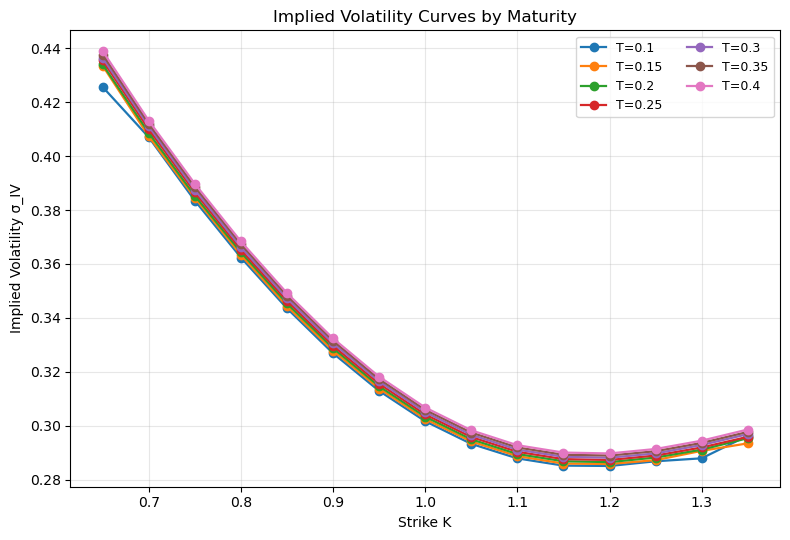

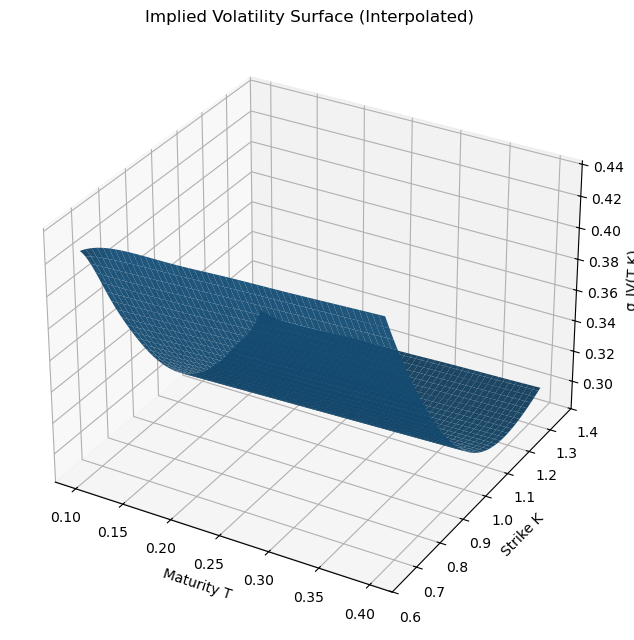

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq
from scipy.interpolate import RectBivariateSpline
from mpl_toolkits.mplot3d import Axes3D
import warnings

warnings.filterwarnings('ignore')

# Config
S0 = 1.0
r = 0.0
data_path = "data.txt"


# Black–Scholes helpers
def bs_call_price(S, K, T, sigma, r=0.0):
    if T <= 0.0:
        return max(S - K, 0.0)
    if sigma <= 0.0:
        return max(S - K, 0.0) * np.exp(-r * T)
    sqrtT = np.sqrt(T)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrtT)
    d2 = d1 - sigma * sqrtT
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)


def implied_vol_call(C_mkt, S, K, T, r=0.0, lo=1e-6, hi=5.0):
    """Implied vol via Brent's method (robust, no external deps)."""
    C_min = max(S - K * np.exp(-r * T), 0.0)
    C_max = S
    C_target = np.clip(C_mkt, C_min + 1e-12, C_max - 1e-12)
    f = lambda sig: bs_call_price(S, K, T, sig, r) - C_target

    f_lo, f_hi = f(lo), f(hi)
    tries = 0
    while f_lo * f_hi > 0.0 and tries < 10:
        hi *= 2.0
        f_hi = f(hi)
        tries += 1
    if f_lo * f_hi > 0.0:
        return lo
    return brentq(f, lo, hi, maxiter=200, xtol=1e-10, rtol=1e-10)


# Load data
raw = np.loadtxt(data_path, comments="#", delimiter=",")
T_col = raw[:, 0]
K_col = raw[:, 1]
C_col = raw[:, 2]

T_unique = np.unique(T_col)
K_unique = np.unique(K_col)
nT, nK = len(T_unique), len(K_unique)

# Arrange prices into a (nT x nK) matrix aligned with the grid
C_mkt = np.empty((nT, nK))
for i, T in enumerate(T_unique):
    mask_T = np.isclose(T_col, T)
    K_row = K_col[mask_T]
    C_row = C_col[mask_T]
    order = np.argsort(K_row)
    K_row = K_row[order]
    C_row = C_row[order]
    if not np.allclose(K_row, K_unique):
        raise ValueError("Strikes per maturity must form a rectangular grid.")
    C_mkt[i, :] = C_row

# Compute σ_IV(T_i, K_j)
sigma_IV = np.zeros_like(C_mkt)
for i, T in enumerate(T_unique):
    for j, K in enumerate(K_unique):
        sigma_IV[i, j] = implied_vol_call(C_mkt[i, j], S0, K, T, r)

# Build w(T,y) spline
# y = log(K/F_T) with r=0 => F_T = S0 => y = log(K)
y_unique = np.log(K_unique)
w_mat = (sigma_IV ** 2) * T_unique.reshape(-1, 1)

kx = min(3, nT - 1)
ky = min(3, nK - 1)
w_spline = RectBivariateSpline(T_unique, y_unique, w_mat, kx=kx, ky=ky, s=0.0)

# Flat extrapolation (clamp to data box)
T_min, T_max = float(T_unique.min()), float(T_unique.max())
y_min, y_max = float(y_unique.min()), float(y_unique.max())


def clamp(x, a, b):
    return min(max(x, a), b)


def w_Ty(T, y):
    Tc = clamp(T, T_min, T_max)
    yc = clamp(y, y_min, y_max)
    return float(w_spline(Tc, yc, dx=0, dy=0))


# IV smiles
plt.figure(figsize=(8, 5.5))
for i, T in enumerate(T_unique):
    plt.plot(K_unique, sigma_IV[i, :], marker="o", linewidth=1.6, label=f"T={T:g}")
plt.xlabel("Strike K")
plt.ylabel("Implied Volatility σ_IV")
plt.title("Implied Volatility Curves by Maturity")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# IV surface
TT = np.linspace(max(T_min, 1e-6), T_max, 50)  # avoid T=0
KK = np.linspace(K_unique.min(), K_unique.max(), 80)
YY = np.log(KK)

sigma_surf = np.zeros((len(TT), len(KK)))
for i, T in enumerate(TT):
    for j, y in enumerate(YY):
        w_val = max(w_Ty(T, y), 1e-12)
        sigma_surf[i, j] = np.sqrt(w_val / max(T, 1e-6))

fig = plt.figure(figsize=(9, 6.5))
ax = fig.add_subplot(111, projection='3d')
TT_grid, KK_grid = np.meshgrid(TT, KK, indexing="ij")
ax.plot_surface(TT_grid, KK_grid, sigma_surf, linewidth=0, antialiased=True, alpha=0.95)
ax.set_xlabel("Maturity T")
ax.set_ylabel("Strike K")
ax.set_zlabel("σ_IV(T,K)")
ax.set_title("Implied Volatility Surface (Interpolated)")
plt.tight_layout()
plt.show()

**2**. <span style="color:blue">(20 points)</span>

Write a function which evaluates a Dupire local volatility at given point, i.e. a function $(t, s) \to \sigma_{Dup}(t, s)$. Please note that it should return an "adequate" value for any input point $(t, s)$ from the considered ranges of strieks and times to expiration. Plot the obtained local volatility surface for a given grid of strikes and times to expiration.

 1) t=0.332187, s=0.909559  ->  σ_Dup=0.350416
 2) t=0.231664, s=1.298735  ->  σ_Dup=0.310927
 3) t=0.357579, s=1.100706  ->  σ_Dup=0.272799
 4) t=0.309210, s=1.225933  ->  σ_Dup=0.288260
 5) t=0.128253, s=0.960390  ->  σ_Dup=0.317900
 6) t=0.392687, s=0.809067  ->  σ_Dup=0.444065
 7) t=0.328342, s=1.038209  ->  σ_Dup=0.283992
 8) t=0.335819, s=0.694672  ->  σ_Dup=0.598682
 9) t=0.138434, s=1.229342  ->  σ_Dup=0.287828
10) t=0.235116, s=1.092165  ->  σ_Dup=0.275590


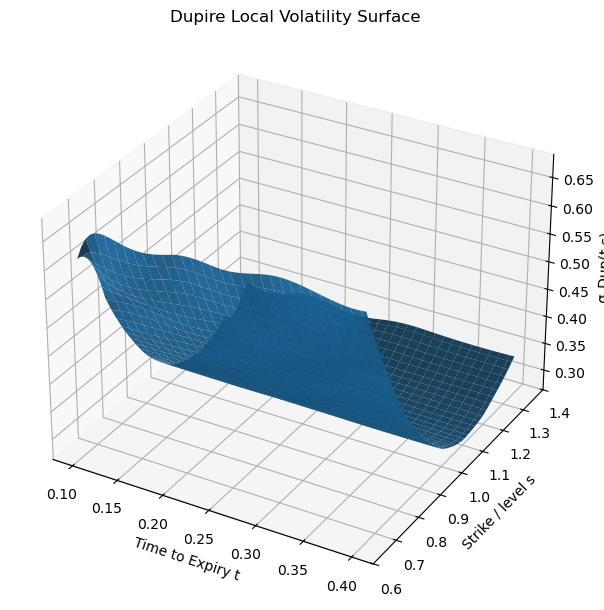

In [24]:
EPS_T = 1e-6  # avoid T=0
EPS_NUM = 1e-12  # numeric floor


# Vectorized, clamped evaluation of w and its partials from the existing spline
def _clamp_vec(x, a, b):
    x = np.asarray(x)
    return np.minimum(np.maximum(x, a), b)


def _w(T, y):
    return w_spline.ev(_clamp_vec(T, T_min, T_max), _clamp_vec(y, y_min, y_max))


def _w_T(T, y):
    return w_spline.ev(_clamp_vec(T, T_min, T_max), _clamp_vec(y, y_min, y_max), dx=1, dy=0)


def _w_y(T, y):
    return w_spline.ev(_clamp_vec(T, T_min, T_max), _clamp_vec(y, y_min, y_max), dx=0, dy=1)


def _w_yy(T, y):
    return w_spline.ev(_clamp_vec(T, T_min, T_max), _clamp_vec(y, y_min, y_max), dx=0, dy=2)


def sigma_dup(t, s, S0=S0, r=r):
    """
    Dupire local volatility σ_Dup(t,s) using the existing total-variance spline.
    Clamps inputs to the data box and guards numerics to return an adequate value everywhere.
    """
    # clamp inputs to your data ranges
    t = float(clamp(t, T_min, T_max))
    t = max(t, EPS_T)
    s = float(np.minimum(np.maximum(s, float(K_unique.min())), float(K_unique.max())))
    s = max(s, 1e-12)

    # y = log(K/F_t); with r=0 in your config, F_t = S0
    F_t = S0 * np.exp(r * t)
    y = np.log(s / F_t)

    w = np.maximum(_w(t, y), EPS_NUM)
    wT = np.maximum(_w_T(t, y), EPS_NUM)
    wy = _w_y(t, y)
    wyy = _w_yy(t, y)

    # Dupire denominator
    denom = 1.0 - (y / w) * wy + 0.25 * ((-0.25) - (1.0 / w) + (y * y) / (w * w)) * (wy * wy) + 0.5 * wyy
    denom = np.maximum(denom, EPS_NUM)

    sigma2 = np.maximum(wT / denom, EPS_NUM)
    return float(np.sqrt(sigma2))


# evaluate σ_Dup on 10 random (t,s) points
rng = np.random.default_rng(42)
t_rand = rng.uniform(T_min, T_max, size=10)
s_rand = rng.uniform(K_unique.min(), K_unique.max(), size=10)

vals = [sigma_dup(t, s) for t, s in zip(t_rand, s_rand)]
for i, (t, s, v) in enumerate(zip(t_rand, s_rand, vals), 1):
    print(f"{i:2d}) t={t:.6f}, s={s:.6f}  ->  σ_Dup={v:.6f}")

# local-vol surface
TT = np.linspace(T_min, T_max, 60)
KK = np.linspace(K_unique.min(), K_unique.max(), 120)
T_grid, K_grid = np.meshgrid(TT, KK, indexing="ij")

# vectorize sigma_dup over the grid
vec_sigma_dup = np.vectorize(sigma_dup, otypes=[float])
LV = vec_sigma_dup(T_grid, K_grid)

fig = plt.figure(figsize=(9, 6.2))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T_grid, K_grid, LV, linewidth=0, antialiased=True, alpha=0.95)
ax.set_xlabel("Time to Expiry t")
ax.set_ylabel("Strike / level s")
ax.set_zlabel("σ_Dup(t,s)")
ax.set_title("Dupire Local Volatility Surface")
plt.tight_layout()
plt.show()

**3**. <span style="color:blue">(20 points)</span>

Implement a Monte-Carlo simulation calculator and price an option with time to expiration $T = 0.25$ for the range of strikes $K = \{ 0.6, 0.7, 0.8, \dots, 1.4\}$. Your calculator should return a range of prices $\{ V(T, K_i)\}$ and implied volatilites $\sigma_{IV}(T, K_i)$ (for each strike $K_i$), with an absolute error not greater than $1\%$ in implied vols for every (almost every) strike $K_i$. Plot on one graph the prices obtained using Monte Carlo and the prices from the file. Also, plot on other graph the implied vols obtained using Monte Carlo and the implied vols obtained in question (1).

Max |IV_MC - IV_file|: 0.017435845185729548
Mean |IV error|: 0.003992184161957322


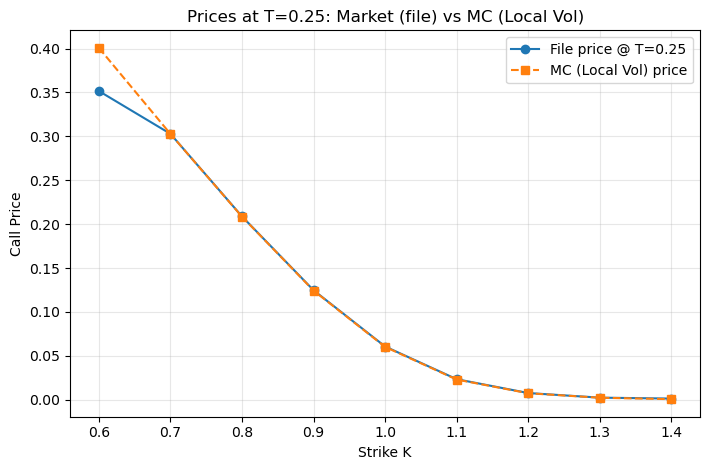

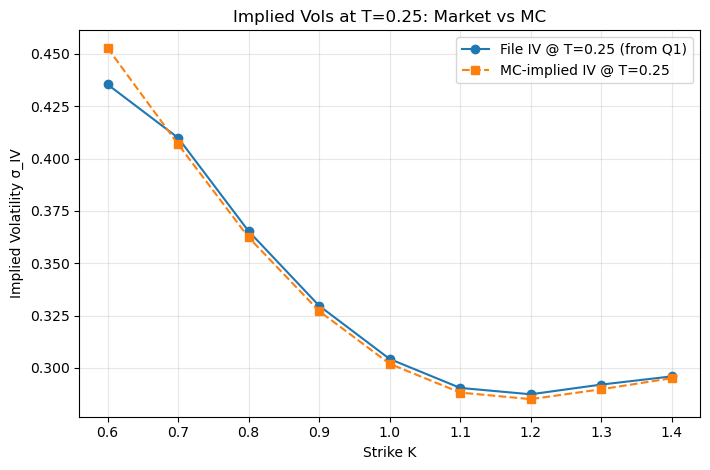

In [29]:
import numpy as np
import matplotlib.pyplot as plt

EPS_T = 1e-6
EPSNUM = 1e-12

# Vectorized Dupire σ(T,S) using the existing w_spline from above
def _clamp_vec(x, a, b):
    x = np.asarray(x)
    return np.minimum(np.maximum(x, a), b)


def sigma_dup_vec(T, S):
    T = np.asarray(T, dtype=float)
    S = np.asarray(S, dtype=float)

    T_eff = _clamp_vec(np.maximum(T, EPS_T), T_min, T_max)
    S_clp = _clamp_vec(np.maximum(S, 1e-12), float(K_unique.min()), float(K_unique.max()))
    F = S0 * np.exp(r * T_eff)
    y = np.log(S_clp / F)

    y_clp = _clamp_vec(y, y_min, y_max)
    w = w_spline.ev(T_eff, y_clp)
    w_T = w_spline.ev(T_eff, y_clp, dx=1, dy=0)
    w_y = w_spline.ev(T_eff, y_clp, dx=0, dy=1)
    w_yy = w_spline.ev(T_eff, y_clp, dx=0, dy=2)

    w = np.maximum(w, EPSNUM)
    w_T = np.maximum(w_T, EPSNUM)

    denom = 1.0 - (y / w) * w_y + 0.25 * ((-0.25) - (1.0 / w) + (y * y) / (w * w)) * (w_y ** 2) + 0.5 * w_yy
    denom = np.maximum(denom, EPSNUM)
    sigma2 = np.maximum(w_T / denom, EPSNUM)
    return np.sqrt(sigma2)


# Monte Carlo pricer (log-Euler, antithetic variates)
def price_local_vol_MC(K, T, paths=60_000, steps=200, seed=2025):
    rng = np.random.default_rng(seed)
    dt = T / steps
    sqrt_dt = np.sqrt(dt)

    half = paths // 2
    X = np.full(half, np.log(S0), dtype=float)
    Xa = X.copy()

    for i in range(steps):
        t_i = i * dt
        S = np.exp(X)
        Sa = np.exp(Xa)

        sig = sigma_dup_vec(np.full_like(S, max(t_i, 1e-8)), S)
        siga = sigma_dup_vec(np.full_like(Sa, max(t_i, 1e-8)), Sa)

        Z = rng.standard_normal(half)
        X += (-0.5 * sig ** 2) * dt + sig * sqrt_dt * Z
        Xa += (-0.5 * siga ** 2) * dt + siga * sqrt_dt * (-Z)

    ST, STa = np.exp(X), np.exp(Xa)
    payoff = 0.5 * (np.maximum(ST - K, 0.0) + np.maximum(STa - K, 0.0))
    return np.exp(-r * T) * payoff.mean()


# Target set: T=0.25, K = {0.6, 0.7, ..., 1.4}
T_target = 0.25
K_list = np.round(np.arange(0.6, 1.41, 0.1), 2)

# Price with MC and back out implied vols using implied_vol_call
V_mc = np.array([price_local_vol_MC(K, T_target, paths=60_000, steps=200) for K in K_list])
IV_mc = np.array([implied_vol_call(p, S0, K, T_target, r) for p, K in zip(V_mc, K_list)])


def interp_in_T(values_matrix, T_grid, T_star):
    # linear interpolation for each strike column
    out = np.empty(values_matrix.shape[1])
    for j in range(values_matrix.shape[1]):
        out[j] = np.interp(T_star, T_grid, values_matrix[:, j])
    return out


if np.any(np.isclose(T_unique, T_target)):
    idx = np.argmin(np.abs(T_unique - T_target))
    C_mkt_T = C_mkt[idx, :].copy()
    IV_mkt_T = sigma_IV[idx, :].copy()
else:
    C_mkt_T = interp_in_T(C_mkt, T_unique, T_target)
    IV_mkt_T = interp_in_T(sigma_IV, T_unique, T_target)

C_file = np.interp(K_list, K_unique, IV_mkt_T * 0.0 + C_mkt_T)  # prices at requested K
IV_file = np.interp(K_list, K_unique, IV_mkt_T)  # IVs at requested K

# Accuracy report: absolute IV error (target ≤ 0.01)
iv_abs_err = np.abs(IV_mc - IV_file)
print("Max |IV_MC - IV_file|:", iv_abs_err.max())
print("Mean |IV error|:", iv_abs_err.mean())

# Prices (MC vs file)
plt.figure(figsize=(7.2, 4.8))
plt.plot(K_list, C_file, 'o-', label='File price @ T=0.25')
plt.plot(K_list, V_mc, 's--', label='MC (Local Vol) price')
plt.xlabel("Strike K");
plt.ylabel("Call Price")
plt.title("Prices at T=0.25: Market (file) vs MC (Local Vol)")
plt.grid(True, alpha=0.3);
plt.legend()
plt.tight_layout();
plt.show()

# Implied vols (MC vs Q1)
plt.figure(figsize=(7.2, 4.8))
plt.plot(K_list, IV_file, 'o-', label='File IV @ T=0.25 (from Q1)')
plt.plot(K_list, IV_mc, 's--', label='MC-implied IV @ T=0.25')
plt.xlabel("Strike K");
plt.ylabel("Implied Volatility σ_IV")
plt.title("Implied Vols at T=0.25: Market vs MC")
plt.grid(True, alpha=0.3);
plt.legend()
plt.tight_layout();
plt.show()